In [25]:
import pandas as pd

In [26]:
# Load the data from a CSV file
df = pd.read_csv('player_match_ratings.csv')

# Display the first few rows of the dataframe
print(df.head())

  competition        date                    match    team  pos pos_role  \
0   Euro 2016  10/06/2016  France - Romania, 2 - 1  France  Sub      Sub   
1   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   FW       FW   
2   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   DF       DC   
3   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   
4   Euro 2016  10/06/2016  France - Romania, 2 - 1  France   MF       MC   

              player  goals  assists  shots_ontarget  ...  betweenness2goals  \
0    Anthony Martial      0        0               1  ...           0.000000   
1     Olivier Giroud      1        0               2  ...           0.050000   
2  Laurent Koscielny      0        0               0  ...           0.000000   
3       N'Golo Kante      0        1               0  ...           0.032258   
4         Paul Pogba      0        0               1  ...           0.000000   

   win  lost  is_home_team  minutesPlayed  game_duration  non_

In [31]:
import pandas as pd
import numpy as np

# ------------------
# Config
# ------------------
BASE_NOTE   = 6.926722   # initial player rating (target mean)
K           = 0.35       # per-match learning rate
DIFF_IMPACT = 1.2        # impact of opponent difficulty on expectation (rating pts)
MINUTES_CAP = 90         # cap for minutes weighting

# ------------------
# Helpers
# ------------------
def minutes_weight(m):
    if pd.isna(m):
        return 0.0
    return float(np.clip(m / MINUTES_CAP, 0.0, 1.0))

def difficulty_from_rank(rank, max_rank):
    # rank=1 (best) -> difficulty=1 (hardest); rank=max_rank (worst) -> ~0 (easiest)
    if pd.isna(rank) or pd.isna(max_rank) or max_rank <= 1:
        return 0.5
    return 1.0 - (float(rank) - 1.0) / (float(max_rank) - 1.0)

def expected_performance(base_note, difficulty, diff_impact=DIFF_IMPACT):
    # Harder opponent (difficulty>0.5) lowers expectation; easier raises it
    return base_note - diff_impact * (difficulty - 0.5) * 2.0

def compute_ratings(pm,
                    K=K,
                    diff_impact=DIFF_IMPACT,
                    keep_global_mean=True,
                    recenter_each_step=False):
    """
    pm must contain: ['date','match','player','w_min','difficulty','P']
    keep_global_mean:
        If True, enforce final (or stepwise) mean rating == BASE_NOTE.
    recenter_each_step:
        If True, re-centers after each date block. Else only one final shift.
    Returns: (ratings_ts, final_ratings)
    """
    player_rating = {}
    history = []

    if recenter_each_step:
        for date, day_df in pm.groupby('date'):
            for row in day_df.itertuples(index=False):
                player = row.player
                perf   = row.P
                w_min  = row.w_min
                diff   = row.difficulty
                match  = row.match
                R_old = player_rating.get(player, BASE_NOTE)

                if pd.isna(perf):
                    history.append((row.date, match, player, R_old, np.nan, np.nan, R_old))
                    continue

                E = expected_performance(BASE_NOTE, diff, diff_impact)
                delta = K * w_min * (perf - E)
                R_new = R_old + delta
                player_rating[player] = R_new
                history.append((row.date, match, player, R_old, perf, E, R_new))

            if keep_global_mean and player_rating:
                current_mean = np.mean(list(player_rating.values()))
                shift = BASE_NOTE - current_mean
                if abs(shift) > 1e-12:
                    # shift stored history entries of this date
                    for i in range(len(history)):
                        d,m,p,Rb,P,E,Ra = history[i]
                        if d == date:
                            history[i] = (d,m,p,Rb+shift,P,E,Ra+shift)
                    # shift live ratings
                    for p in player_rating:
                        player_rating[p] += shift
    else:
        for row in pm.itertuples(index=False):
            player = row.player
            perf   = row.P
            w_min  = row.w_min
            diff   = row.difficulty
            date   = row.date
            match  = row.match
            R_old = player_rating.get(player, BASE_NOTE)

            if pd.isna(perf):
                history.append((date, match, player, R_old, np.nan, np.nan, R_old))
                continue

            E = expected_performance(BASE_NOTE, diff, diff_impact)
            delta = K * w_min * (perf - E)
            R_new = R_old + delta
            player_rating[player] = R_new
            history.append((date, match, player, R_old, perf, E, R_new))

        # Final global recenter
        if keep_global_mean and player_rating:
            final_mean = np.mean(list(player_rating.values()))
            shift = BASE_NOTE - final_mean
            if abs(shift) > 1e-12:
                history = [(d,m,p,Rb+shift,P,E,Ra+shift) for (d,m,p,Rb,P,E,Ra) in history]
                for p in player_rating:
                    player_rating[p] += shift

    ratings_ts = pd.DataFrame(history,
                              columns=["date","match","player","rating_before","P","E","rating_after"])
    final_ratings = (ratings_ts.sort_values("date")
                     .groupby("player", as_index=False)["rating_after"]
                     .last()
                     .rename(columns={"rating_after":"final_rating"}))
    return ratings_ts, final_ratings

# ------------------
# Load & prep
# ------------------
pm0 = pd.read_csv("player_match_ratings.csv")
pm0["date"] = pd.to_datetime(pm0["date"], errors="coerce")
pm0 = pm0.sort_values(["date","match","player"]).reset_index(drop=True)

# Minutes weighting
pm0["w_min"] = pm0["minutesPlayed"].apply(minutes_weight)

# Difficulty (scale opponent_ranking per competition)
max_rank_df = (pm0.groupby("competition", dropna=False)["opponent_ranking"]
                  .max().rename("max_rank").reset_index())
pm0 = pm0.merge(max_rank_df, on="competition", how="left")
pm0["difficulty"] = pm0.apply(
    lambda r: difficulty_from_rank(r["opponent_ranking"], r["max_rank"]), axis=1
)

# ------------------
# Build three datasets with their own P
# ------------------
base_cols = ["date","match","player","w_min","difficulty"]

# 1) Average (ignores NaNs)
pm_avg = pm0[base_cols].copy()
pm_avg["P"] = pm0[["human_rating","non_human_rating"]].mean(axis=1)

# 2) Human-only
pm_hum = pm0[base_cols].copy()
pm_hum["P"] = pm0["human_rating"]

# 3) Non-human-only
pm_ai = pm0[base_cols].copy()
pm_ai["P"] = pm0["non_human_rating"]

# ------------------
# Compute ratings (final mean preserved at BASE_NOTE)
# ------------------
ts_avg, fin_avg = compute_ratings(pm_avg, keep_global_mean=True, recenter_each_step=False)
ts_hum, fin_hum = compute_ratings(pm_hum, keep_global_mean=True, recenter_each_step=False)
ts_ai,  fin_ai  = compute_ratings(pm_ai,  keep_global_mean=True, recenter_each_step=False)

# Label and stack time series
ts_avg["system"] = "average"
ts_hum["system"] = "human"
ts_ai["system"]  = "ai"
ts_all = pd.concat([ts_avg, ts_hum, ts_ai], ignore_index=True)

# Merge final ratings (wide)
fin_avg = fin_avg.rename(columns={"final_rating":"final_rating_avg"})
fin_hum = fin_hum.rename(columns={"final_rating":"final_rating_human"})
fin_ai  = fin_ai.rename(columns={"final_rating":"final_rating_ai"})

final_all = (fin_avg
             .merge(fin_hum, on="player", how="outer")
             .merge(fin_ai,  on="player", how="outer"))

# ------------------
# Save
# ------------------
final_all.to_csv("final_ratings_three_systems.csv", index=False)
ts_all.to_csv("ratings_timeseries_three_systems.csv", index=False)

print("Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv")
print("Global mean (average system) final rating:",
      round(final_all["final_rating_avg"].mean(), 6))

Saved final_ratings_three_systems.csv and ratings_timeseries_three_systems.csv
Global mean (average system) final rating: 6.926722


Top 5 players vs diff_impact:

   diff_impact      top1_player  top1_rating  top2_player  top2_rating  \
0         0.00  Kevin De Bruyne      22.6581  Eden Hazard      17.7631   
1         0.25  Kevin De Bruyne      22.5121  Eden Hazard      17.7954   
2         0.50  Kevin De Bruyne      22.3660  Eden Hazard      17.8278   
3         0.75  Kevin De Bruyne      22.2199  Eden Hazard      17.8601   
4         1.00  Kevin De Bruyne      22.0739  Eden Hazard      17.8925   
5         1.25  Kevin De Bruyne      21.9278  Eden Hazard      17.9248   
6         1.50  Kevin De Bruyne      21.7817  Eden Hazard      17.9572   
7         2.00  Kevin De Bruyne      21.4896  Eden Hazard      18.0219   
8         2.50  Kevin De Bruyne      21.1974  Eden Hazard      18.0866   
9         3.00  Kevin De Bruyne      20.9053  Eden Hazard      18.1513   

     top3_player  top3_rating    top4_player  top4_rating    top5_player  \
0  Mohamed Salah      17.0475    David Silva      16.6580     Harry Kane   
1 

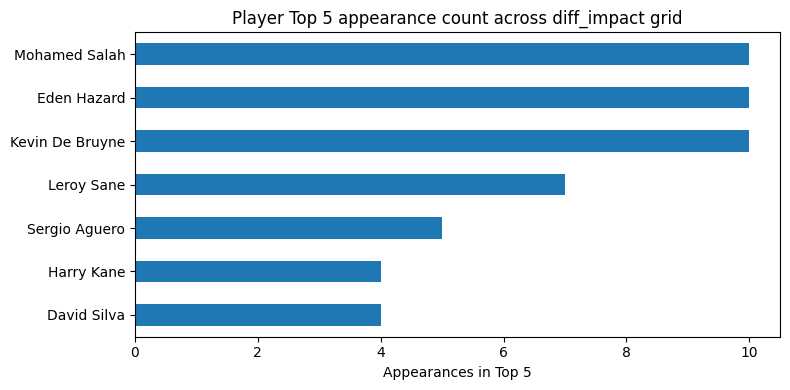

In [32]:
# Grid search over diff_impact (opponent difficulty weight) and its effect on Top 5 (average system)
import pandas as pd
import matplotlib.pyplot as plt

diff_values = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]  # adjust range as needed
results = []

for dv in diff_values:
    ts_tmp, fin_tmp = compute_ratings(pm_avg,
                                      K=K,
                                      diff_impact=dv,
                                      keep_global_mean=True,
                                      recenter_each_step=False)
    fin_sorted = fin_tmp.sort_values('final_rating', ascending=False).reset_index(drop=True)
    top5 = fin_sorted.head(5).copy()
    row = {'diff_impact': dv}
    for i, r in top5.iterrows():
        row[f'top{i+1}_player'] = r['player']
        row[f'top{i+1}_rating'] = round(r['final_rating'], 4)
    results.append(row)

diff_grid = pd.DataFrame(results)
print("Top 5 players vs diff_impact:\n")
print(diff_grid)

# Show how often each player appears in Top 5
all_top_players = pd.Series([p for row in results for k,p in row.items() if k.startswith('top') and k.endswith('_player')])
freq = all_top_players.value_counts()
print("\nAppearance frequency in Top 5 (across diff_impact values):")
print(freq)

# Optional: visualize stability (number of changes vs previous diff_impact)
changes = []
prev_set = None
for _, row in diff_grid.iterrows():
    current_set = {row['top1_player'], row['top2_player'], row['top3_player'], row['top4_player'], row['top5_player']}
    if prev_set is None:
        changes.append(0)
    else:
        changes.append(len(current_set.symmetric_difference(prev_set)))
    prev_set = current_set
diff_grid['top5_membership_changes_vs_prev'] = changes
print("\nMembership changes vs previous diff_impact:")
print(diff_grid[['diff_impact','top5_membership_changes_vs_prev']])

# Plot frequency
plt.figure(figsize=(8,4))
freq.sort_values(ascending=True).plot(kind='barh', color='tab:blue')
plt.xlabel("Appearances in Top 5")
plt.title("Player Top 5 appearance count across diff_impact grid")
plt.tight_layout()
plt.show()

In [33]:
# Derive suggested diff_impact scale
perf_dev = (pm_avg['P'] - BASE_NOTE).dropna()
diff_dev = (pm_avg['difficulty'] - 0.5).dropna()

std_perf = perf_dev.std()
std_diff = diff_dev.std()
target = std_perf / (2 * std_diff) if std_diff > 0 else 1.0

multipliers = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2]
focused_diff_values = sorted({round(target * m, 3) for m in multipliers})

print("std_perf:", round(std_perf,4), "std_diff:", round(std_diff,4))
print("Target diff_impact ~", round(target,3))
print("Focused diff_values:", focused_diff_values)

# Add a wider exploratory set (union)
wide_extra = [0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5]
diff_values = sorted(set(focused_diff_values + wide_extra))
print("Final grid:", diff_values)

std_perf: 0.7496 std_diff: 0.3074
Target diff_impact ~ 1.219
Focused diff_values: [0.0, 0.305, 0.61, 0.914, 1.219, 1.524, 1.829, 2.439]
Final grid: [0.0, 0.25, 0.305, 0.5, 0.61, 0.75, 0.914, 1, 1.219, 1.5, 1.524, 1.829, 2, 2.439, 3, 4, 5]


Best 3: ['Kevin De Bruyne', 'Eden Hazard', 'Mohamed Salah']
Worst 3: ['Bobby Wood', 'Martin Olsson', 'Gideon Jung']


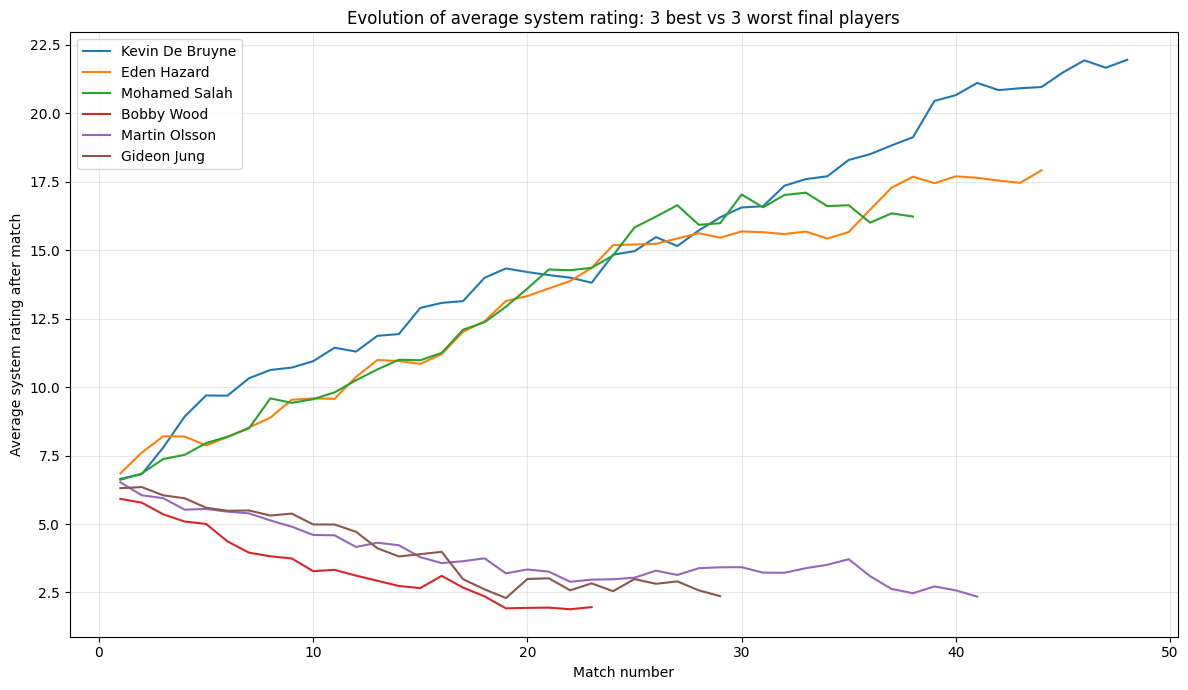

In [34]:
import matplotlib.pyplot as plt

# Select 3 best and 3 worst (average system)
fa_clean = final_all.dropna(subset=["final_rating_avg"])
best_players  = fa_clean.sort_values("final_rating_avg", ascending=False).head(3)["player"].tolist()
worst_players = fa_clean.sort_values("final_rating_avg", ascending=True).head(3)["player"].tolist()
players_to_plot = best_players + worst_players

print("Best 3:", best_players)
print("Worst 3:", worst_players)

# Time series for these players (average system only)
ts_subset = ts_avg[ts_avg["player"].isin(players_to_plot)].copy()
# Order by date then compute a per-player match index
ts_subset = ts_subset.sort_values(["player","date","match"])
ts_subset["match_number"] = ts_subset.groupby("player").cumcount() + 1

plt.figure(figsize=(12,7))
for p in players_to_plot:
    d = ts_subset[ts_subset["player"] == p]
    plt.plot(d["match_number"], d["rating_after"], label=p)

plt.xlabel("Match number")
plt.ylabel("Average system rating after match")
plt.title("Evolution of average system rating: 3 best vs 3 worst final players")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Worst 3: ['Bobby Wood', 'Martin Olsson', 'Gideon Jung']
Middle 3: ['Julian Weigl', 'Emiliano Insua', 'Corentin Tolisso']
Best 3: ['Kevin De Bruyne', 'Eden Hazard', 'Mohamed Salah']


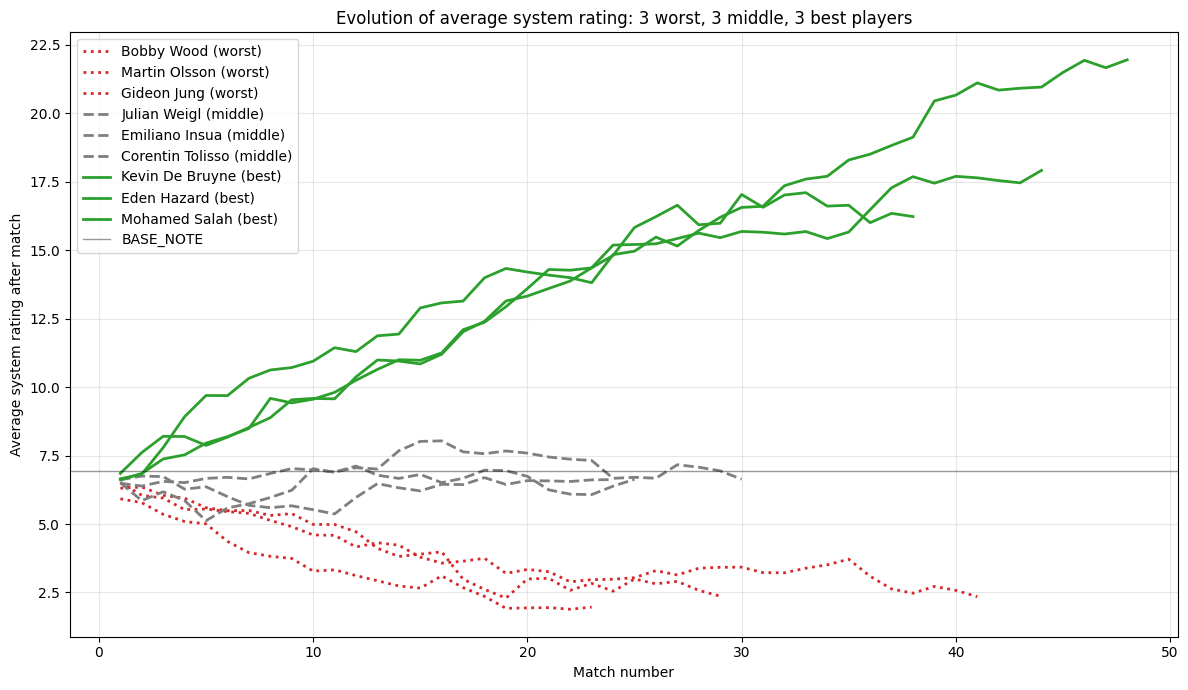

In [35]:
# ...existing code...
import matplotlib.pyplot as plt

# Select 3 best, 3 middle, 3 worst (average system)
fa_clean = final_all.dropna(subset=["final_rating_avg"]).copy()

# Worst (lowest)
worst_players = (fa_clean.sort_values("final_rating_avg", ascending=True)
                          .head(3)["player"].tolist())

# Best (highest)
best_players = (fa_clean.sort_values("final_rating_avg", ascending=False)
                         .head(3)["player"].tolist())

# Middle (around median)
fa_sorted = fa_clean.sort_values("final_rating_avg", ascending=True).reset_index(drop=True)
n = len(fa_sorted)
if n <= 3:
    middle_players = fa_sorted["player"].tolist()  # fallback
else:
    median_idx = n // 2
    candidate_idxs = [median_idx - 1, median_idx, median_idx + 1]
    candidate_idxs = [i for i in candidate_idxs if 0 <= i < n]
    # Ensure exactly 3 if possible
    if len(candidate_idxs) > 3:
        candidate_idxs = candidate_idxs[:3]
    elif len(candidate_idxs) < 3 and n >= 3:
        # pad from center outward
        needed = 3 - len(candidate_idxs)
        extra = []
        for i in range(n):
            if i not in candidate_idxs:
                extra.append(i)
            if len(extra) == needed:
                break
        candidate_idxs += extra
    middle_players = fa_sorted.loc[sorted(candidate_idxs), "player"].tolist()

players_to_plot = worst_players + middle_players + best_players

print("Worst 3:", worst_players)
print("Middle 3:", middle_players)
print("Best 3:", best_players)

# Time series subset (average system)
ts_subset = ts_avg[ts_avg["player"].isin(players_to_plot)].copy()
ts_subset = ts_subset.sort_values(["player","date","match"])
ts_subset["match_number"] = ts_subset.groupby("player").cumcount() + 1

# Group assignment
group_map = {}
for p in worst_players:  group_map[p] = "worst"
for p in middle_players: group_map[p] = "middle"
for p in best_players:   group_map[p] = "best"
ts_subset["group"] = ts_subset["player"].map(group_map)

style_cfg = {
    "worst":  {"linestyle":":",  "linewidth":2, "color":"tab:red"},
    "middle": {"linestyle":"--", "linewidth":2, "color":"tab:gray"},
    "best":   {"linestyle":"-",  "linewidth":2, "color":"tab:green"},
}

plt.figure(figsize=(12,7))
for player in players_to_plot:
    d = ts_subset[ts_subset["player"] == player]
    g = group_map[player]
    plt.plot(d["match_number"],
             d["rating_after"],
             label=f"{player} ({g})",
             **style_cfg[g])

# Reference line at BASE_NOTE
plt.axhline(BASE_NOTE, color="black", linewidth=1, alpha=0.4, label="BASE_NOTE")

plt.xlabel("Match number")
plt.ylabel("Average system rating after match")
plt.title("Evolution of average system rating: 3 worst, 3 middle, 3 best players")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
#

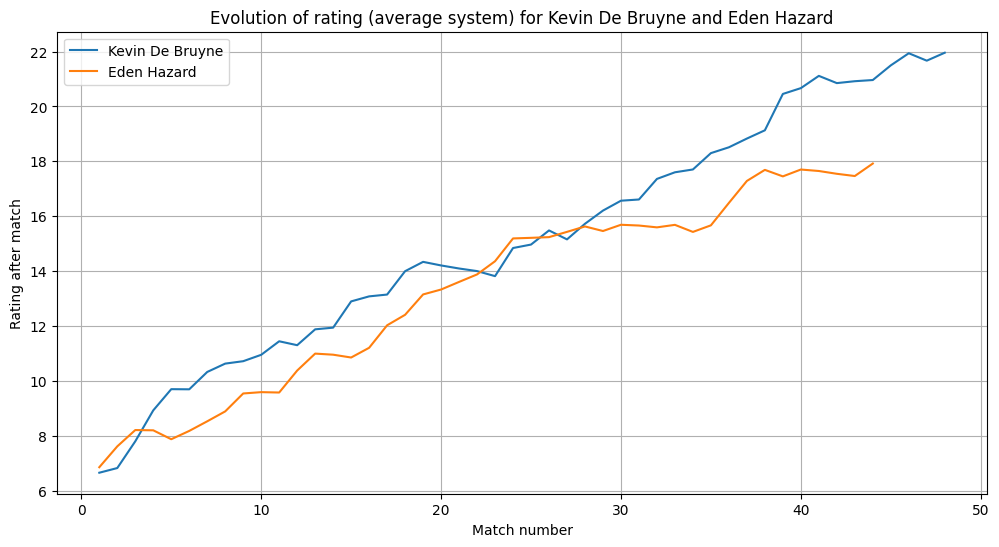

In [36]:
import matplotlib.pyplot as plt

# Filter for Kevin De Bruyne and Eden Hazard in the average system
players = ["Kevin De Bruyne", "Eden Hazard"]
df_plot = ts_avg[ts_avg["player"].isin(players)].copy()

# Add match number per player
df_plot["match_number"] = df_plot.groupby("player").cumcount() + 1

plt.figure(figsize=(12, 6))
for player in players:
    player_data = df_plot[df_plot["player"] == player]
    plt.plot(player_data["match_number"], player_data["rating_after"], label=player)

plt.xlabel("Match number")
plt.ylabel("Rating after match")
plt.title("Evolution of rating (average system) for Kevin De Bruyne and Eden Hazard")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Show the 10 best players by each rating system
print("Top 10 by average note:")
print(final_all.sort_values("final_rating_avg", ascending=False)[["player", "final_rating_avg"]].head(10))

print("\nTop 5 by human note:")
print(final_all.sort_values("final_rating_human", ascending=False)[["player", "final_rating_human"]].head(5))

print("\nTop 5 by non-human note:")
print(final_all.sort_values("final_rating_ai", ascending=False)[["player", "final_rating_ai"]].head(5))

Top 10 by average note:
                player  final_rating_avg
260    Kevin De Bruyne         21.956995
137        Eden Hazard         17.918376
355      Mohamed Salah         16.231421
285         Leroy Sane         15.509101
449      Sergio Aguero         14.889274
178         Harry Kane         14.810234
113        David Silva         14.638633
84   Christian Eriksen         14.040375
413    Raheem Sterling         14.016823
419       Riyad Mahrez         12.761864

Top 5 by human note:
              player  final_rating_human
260  Kevin De Bruyne           23.259631
355    Mohamed Salah           16.965527
113      David Silva           16.101798
285       Leroy Sane           16.029491
413  Raheem Sterling           15.497393

Top 5 by non-human note:
              player  final_rating_ai
260  Kevin De Bruyne        20.512307
137      Eden Hazard        20.422177
178       Harry Kane        17.263934
355    Mohamed Salah        15.355263
449    Sergio Aguero        15.201336
